In [1]:
from yamlscript_histdata import histdata_parser
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pandas as pd
import numpy as np
import mplhep as hep
import boost_histogram as bh

In [2]:
df1, df2 = histdata_parser("CR_ttc_prefit.yaml")

histdata_parser ran in 52 ms.


In [7]:
dflist          = df1.loc[['Samples']]
hist_list       = list(reversed(df1.loc[['Samples'], 'Yield'].tolist()))
histlist_edges  = df2.loc[['BinEdges'],0][0]
histlist_labels = ['$' + x.replace('#', '\\') + '$' for x in reversed(dflist.index.get_level_values(1).tolist())]
total_yield     = df1.loc[['Total'],'Yield'][0]
data_yield      = df1.loc[['Data'],'Yield'][0]
total_errup     = df1.loc[['Total'],'Yield'][1]
total_errdown   = df1.loc[['Total'],'Yield'][2]
xaxis_label     = '$' + df2.loc[['XaxisLabel'], 0][0].replace('#', '\\') + '$'

In [4]:
histlist_labels

['$tH$',
 '$tWH$',
 '$t\\bar{t} + \\geq1b$',
 '$t\\bar{t} + \\geq1c$',
 '$t\\bar{t} + light$',
 '$t\\bar{t} + H$',
 '$t\\bar{t} + Z$',
 '$t\\bar{t} + W$',
 '$tZq$',
 '$tWZ$',
 '$Single top Wt$',
 '$Single top t-channel$',
 '$Single top s-channel$',
 '$W+jets$',
 '$Z+jets$',
 '$VV$',
 '$other Higgs$',
 '$Rare top$',
 '$Non-prompt$']

In [24]:
class EmptyPlot():
    
    def __init__(self, title=None, layout=(1,1), size=(6.4,4.8), style="ATLAS"):
        
        self.title  = title
        self.layout = layout
        self.size   = size
        self.style  = style
        
        self.container1d = []
        self.container2d = []
        self.colorlist   = []
    
    def create_canvas(self):
        self.fig = plt.figure(figsize=self.size)
        hep.style.use(self.style) # available syles are: {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}

    def make_grid(self, **grid_kw):
        self.gs = gridspec.GridSpec(self.layout[0], self.layout[1], **grid_kw) # there has to be a smarter way to unpack tuple
    
    def make_subplot(self, start_row, end_row, start_col, end_col, **subplot_kw): # these args must be allowed by layout size
        return self.fig.add_subplot(self.gs[start_row:end_row,start_col:end_col], **subplot_kw)
    
    def set_majorticks(self, ax, **ticks_kw):
        ax.tick_params(**ticks_kw)
    
    def set_minorticks(self, ax, **ticks_kw):
        ax.minorticks_on()
        ax.tick_params(**ticks_kw)
    
    def set_color(self, colormap="viridis", reverse=False): # create custom color map
        
        clist = []
        source = self.dflist # list of units to be stacked
        pct_max = 99 # max percentile of color ramp
        pct_min = 1  # min percentile of color ramp
        cmap = mpl.cm.get_cmap(colormap)
        # number of items in data source
        n = len(source)
        # list of values between 0.00 and 1.00; length equals length of data source
        sequence = list(i/100 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))
        # reverse if required
        sequence = sequence if not reverse else reversed(sequence)
        # create list of colors
        for i in sequence:
            color = cmap(i) 
            clist.append(color)

        self.colorlist = clist
    
    def saveimage(self, name):
        self.fig.savefig(name, facecolor='white', transparent=False, dpi=1200, bbox_inches='tight')

        

class PythRatio(EmptyPlot):
    
    def __init__(self, toptitle=None, bottitle=None, topylabel="Events", botylabel="Data/Pred.", **kwargs):
        
        super().__init__(layout=(2,1), **kwargs)
        
        ### these should be retrived from filled object -------------
        self.dflist          = dflist
        self.histlistedges   = histlist_edges
        self.histlisttotal   = total_yield
        self.histlistdata    = data_yield
        self.histlistlabels  = histlist_labels
        self.histlisterrup   = total_errup
        self.histlisterrdown = total_errdown
        self.histlistxlabel  = xaxis_label
        ### ---------------------------------------------------------
        
        self.create_canvas()
        self.make_grid(hspace=0, height_ratios=[4,1])
        self.topax = self.make_subplot(0, 1, 0, 1)
        self.botax = self.make_subplot(1, 2, 0, 1)
        self.toptitle = toptitle
        self.bottitle = bottitle
        self.topylabel = topylabel
        self.botylabel = botylabel
        self.set_color() # set default colormap
        
        # the lower part in the ratio plot is the data divided by the total hist cont
        self.ratiovalues = [i/j for i, j in zip(self.histlistdata, self.histlisttotal)]
        
        # set rcParams for the plot
        mpl.rcParams['legend.columnspacing'] = 0.5
        mpl.rcParams['legend.labelspacing']  = 0.1
        mpl.rcParams['legend.loc']           = 'upper right'
        mpl.rcParams['legend.markerscale']   = 1.2
        mpl.rcParams['legend.handletextpad'] = 0.15
        mpl.rcParams['legend.fontsize']      = 15

    def fill(self, obj): # put in the figure histogram object(s)
        self.container1d.append(obj)
        
    def display(self, save=False):
        
        ### overall figure ###
        self.fig.suptitle(self.title)
        
        
        ### top figure ###
        
        # ===== stacked histogram =====
        hep.histplot(self.container1d[0], ax=self.topax, bins=self.histlistedges, stack=True, fill=True, 
                     label=self.histlistlabels, color=self.colorlist, edgecolor='k')
        # ===== data scatter points =====
        hep.histplot(self.histlistdata, ax=self.topax, bins=self.histlistedges, histtype='errorbar', color='k', 
                     label="Data", markersize=15)
        # ===== data error histograms =====
        # hep.histplot(self.histlisterrup, ax=self.topax, bins=self.histlistedges, histtype='fill', color='k',# baseline=self.histlisttotal,
        #              label="Error on total", linewidth=0, alpha=0.5, hatch='///')
        # hep.histplot(self.histlisterrdown, ax=self.topax, bins=self.histlistedges, color='k', bottom=self.histlisttotal, 
        #              label="Error on total", fill=False, linewidth=0, alpha=0.5, hatch='///')
        
        # ===== customisations =====
        self.set_majorticks(self.topax, direction='in', length=10, bottom=True, top=True, left=True, right=True)
        self.set_minorticks(self.topax, direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        self.topax.ticklabel_format(style='plain')
        self.topax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        self.topax.set_xticklabels([])
        self.topax.set_ylim([0, 12_000])
        self.topax.set_title(self.toptitle)
        self.topax.set_ylabel(self.topylabel)
        self.topax.legend(ncol=2, handlelength=1.7)
        hep.atlas.label(ax=self.topax, label="Internal", data=True, lumi=139)

        ### bot figure ###

        hep.histplot(self.ratiovalues, ax=self.botax, bins=self.histlistedges, histtype='errorbar', color='k', markersize=15)
        
        # ===== customisations =====
        self.set_majorticks(self.botax, direction='in', length=10, bottom=True, top=True, left=True, right=True)
        self.set_minorticks(self.botax, direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        self.botax.set_ylim([0.5, 1.5])
        self.botax.axhline(1, color='k', linestyle='--')
        self.botax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        self.botax.set_yticklabels(["0.5", "0.75", "1.00", "1.25", ""])
        self.botax.set_yticks([0.5, 0.75, 1, 1.25, 1.5])
        self.botax.set_ylabel(self.botylabel)
        self.botax.set_xlabel(self.histlistxlabel)
        self.botax.set_title(self.bottitle)
        
        if save:
            self.saveimage(type(self).__name__)

/tmp/flciciri/ipykernel_7929/3842728072.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.botax.set_yticklabels(["0.5", "0.75", "1.00", "1.25", ""])


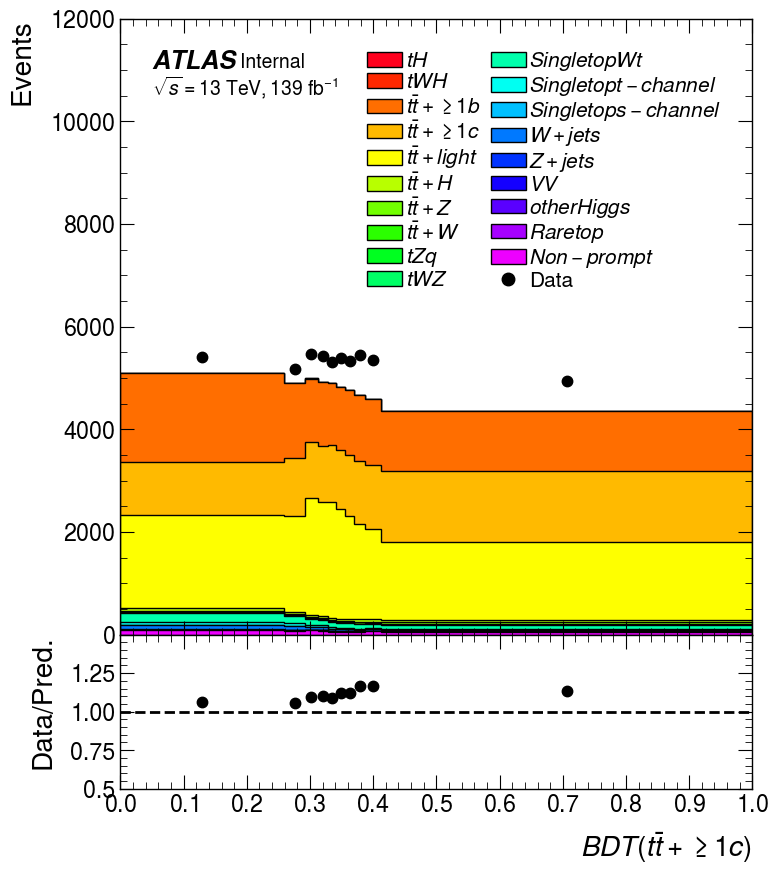

In [25]:
obj1 = PythRatio(size=(8,10))
obj1.fill(hist_list)
obj1.set_color(reverse=True, colormap="gist_rainbow")
obj1.display(save=True)